# Intro to Anomaly Detection with PyOD(Python Outlier Detection) and ADbench

*Written by Joshua Harvey, for Prospect 33, 2024.*

Anomaly detection involves identifying observations that deviate significantly from the norm. It is a key component of data quality processes (DQ), along with missing value imputation and data drift.

PyOD is a comprehensive library for detecting outliers in multivariate data. It provides various algorithms and utilities for anomaly detection.

ADbench is a set of benchmark datasets pooled from a large number of published papers and previously used open-source datasets. For this notebook, we are only using the ADbench datasets, so these can be downloaded separately if you have issues with installing ADbench (eg dependency clashes).

Shap is a library for implementing the SHAP (Shapley Additive exPlanations) explainability framework. It provides both model-specific and model-agnostic approaches for ML explainability.


## 1. Setup and Installation
Let's start by installing the required libraries. It is strongly recommended to build inside a dedicated environment.

In [1]:
import warnings
warnings.filterwarnings("ignore")

#%pip install pyod #adbench matplotlib seaborn shap

We also need to download the datasets for ADbench

from adbench.myutils import Utils
utils = Utils() # utility function
# download datasets from the remote github repo
utils.download_datasets(repo='github')

In [2]:
#!pip install shap matplotlib

## 2. Load and Explore an ADbench Dataset

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from pyod.models.knn import KNN 
from pyod.models.iforest import IForest
# Example anomaly detector
import shap  # For SHAP values explanation

# Load a dataset from ADbench
adbench_dir = '/path/to/your/environment/eg/lib/python3.11/site-packages/adbench/datasets/Classical/' # change this to your adbench directory
dataset_name = '2_annthyroid.npz'  # You can change this to another dataset, see https://github.com/Minqi824/ADBench/tree/main/adbench/datasets/Classical
data = np.load(adbench_dir+dataset_name, allow_pickle=True)
X, y = data['X'], data['y']

In [4]:
import pandas as pd
data=pd.read_csv('annthyroid.csv')
#data.columns=['A','B','C','D','E','F','label']
#data = data.drop(["Unnamed: 22", "Unnamed: 23"], axis=1)
data = data.rename({'label ': 'Outlier_label'}, axis=1)
data.head()

,0,1,2,3,4,5,label
0,0.73,0.00060,0.015,0.120,0.082,0.146,0
1,0.24,0.00025,0.030,0.143,0.133,0.108,0
2,0.47,0.00190,0.024,0.102,0.131,0.078,0
3,0.64,0.00090,0.017,0.077,0.090,0.085,0
4,0.23,0.00025,0.026,0.139,0.090,0.153,0


In [5]:
X = data.drop("label", axis=1).values

y = data["label"]

In [6]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#print(f"Dataset: {dataset_name}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (5040, 6)
Test set shape: (2160, 6)


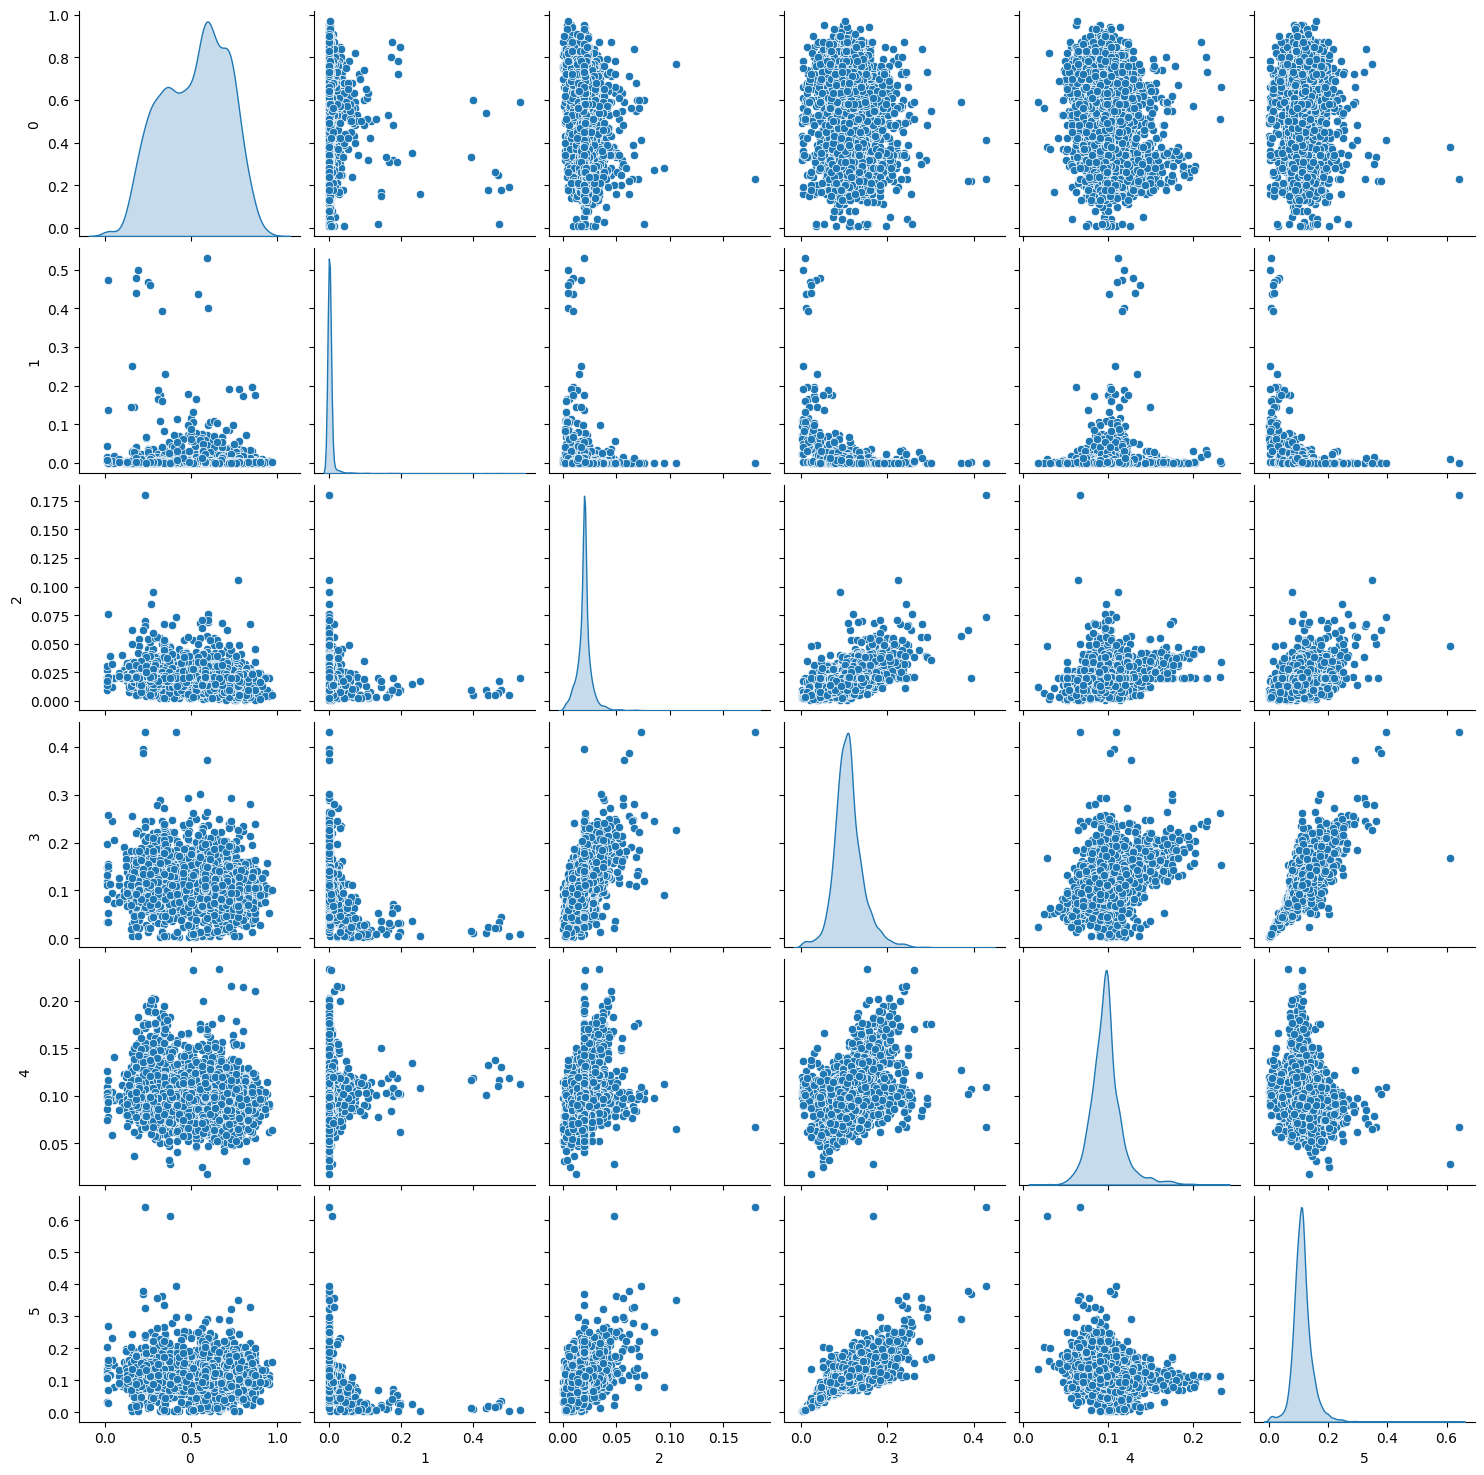

In [7]:
import seaborn as sns
# Visualize the data distribution (use a subset if too large)
sns.pairplot(pd.DataFrame(X_train), diag_kind='kde')
plt.show()

# 3. Using PyOD for Anomaly Detection


## (a) KNN

In [8]:
# Initialize a PyOD model (KNN as an example)
clf = KNN()
# Train the model
clf.fit(X_train)

# Predict anomalies on the test set
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

## 4. Evaluating Anomaly Detection Model Performance

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Evaluate the model
auc = roc_auc_score(y_test, y_test_scores)
accuracy = accuracy_score(y_test, y_test_pred)
auc_knn=auc
accuracy_knn=accuracy
print(f"ROC AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")

ROC AUC: 0.7522
Accuracy: 0.8861


## 5. Visualizing Results

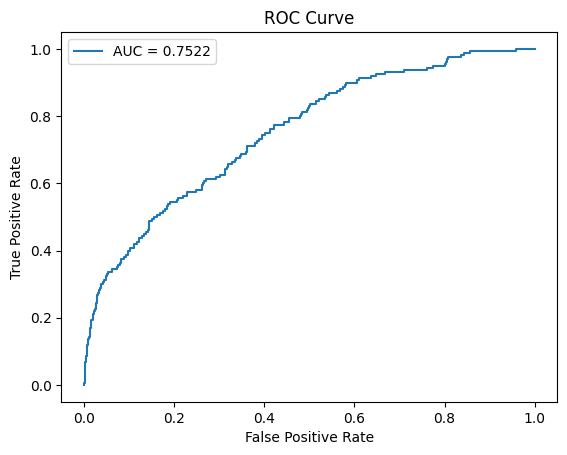

In [10]:
# Plot ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

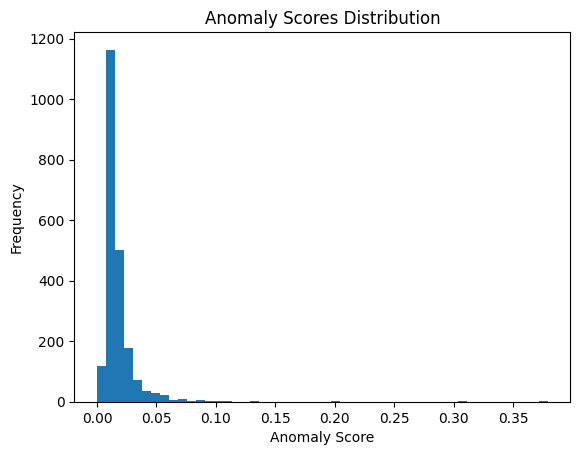

In [11]:
# Visualize anomaly scores
plt.hist(y_test_scores, bins=50)
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Anomaly Scores Distribution')
plt.show()

In [12]:
# Visualize the data distribution (use a subset if too large), coloring true positives, false positives, true negatives, and false negatives
df = pd.DataFrame(X_train)
df['y'] = y_train
df['y_pred'] = clf.predict(X_train)

In [13]:
def label_outcome(row):
    if row['y'] == 1 and row['y_pred'] == 1:
        return 'TP'  # True Positive
    elif row['y'] == 0 and row['y_pred'] == 1:
        return 'FP'  # False Positive
    elif row['y'] == 0 and row['y_pred'] == 0:
        return 'TN'  # True Negative
    elif row['y'] == 1 and row['y_pred'] == 0:
        return 'FN'  # False Negative


In [14]:
df['outcome'] = df.apply(label_outcome, axis=1)
df = df.drop(['y', 'y_pred'], axis=1)
df.head()

,0,1,2,3,4,5,outcome
0,0.28,0.00208,0.017,0.116,0.101,0.115,TN
1,0.74,0.00300,0.012,0.096,0.093,0.103,None
2,0.85,0.00140,0.006,0.124,0.096,0.129,None
3,0.34,0.00680,0.024,0.096,0.104,0.090,None
4,0.46,0.00091,0.024,0.124,0.104,0.118,None


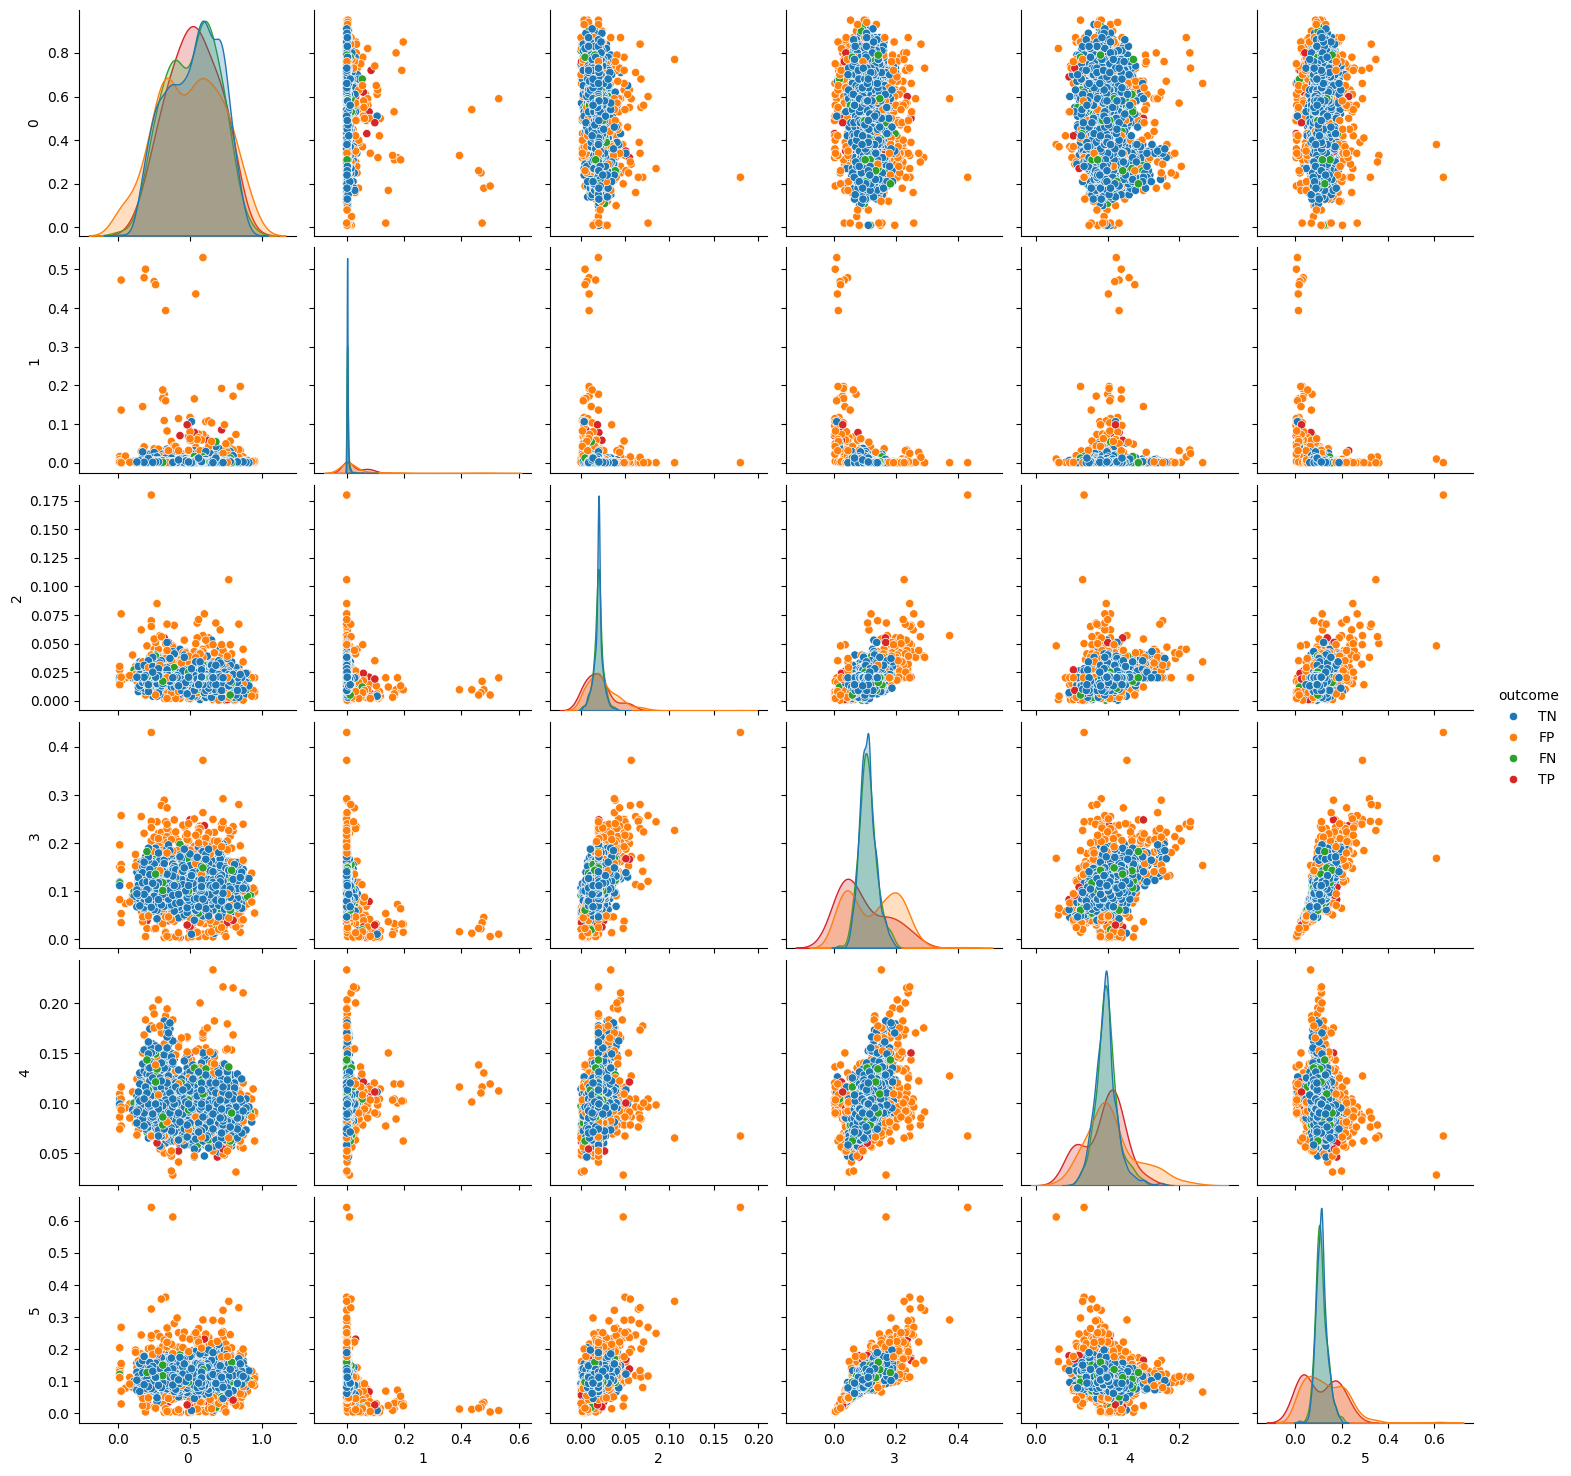

In [15]:
# Visualize the data distribution (use a subset if too large), coloring true positives, false positives, true negatives, and false negatives

pp = sns.pairplot(df, diag_kind='kde', hue='outcome',  # color by outcome
                  diag_kws=dict(common_norm=False))  # scale kde independently for each outcome
plt.show()

## 6. Explainability with SHAP

In [16]:
# find index of first true positive
first_tp_index = df[df['outcome'] == 'TP'].index[0]
print(f"Index of the first True Positive: {first_tp_index}")

Index of the first True Positive: 115


In [17]:
!pip3 install numpy==1.23.1

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [18]:
import numpy as np
np.bool = np.bool_
np.int=np.int_

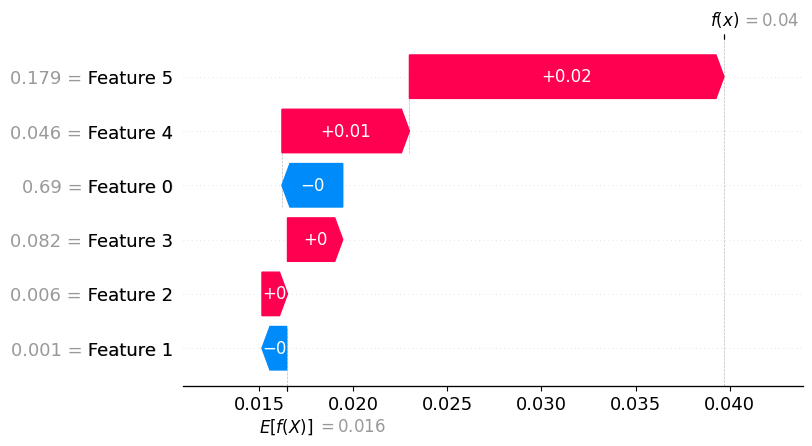

In [19]:
# Fit SHAP explainer and obtain SHAP values for one observation -- TRUE POSITIVE
explainer = shap.explainers.Exact(clf.decision_function, X_train)
shap_values_exact = explainer(np.array([X_train[first_tp_index,]]))
shap.plots.waterfall(shap_values_exact[0])

# (b) Isolation Forest

In [20]:
# Initialize a PyOD model (KNN as an example)
clf = IForest()
# Train the model
clf.fit(X_train)

# Predict anomalies on the test set
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

In [21]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Evaluate the model
auc = roc_auc_score(y_test, y_test_scores)
accuracy = accuracy_score(y_test, y_test_pred)
auc_IF=auc
accuracy_IF=accuracy

print(f"ROC AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")

ROC AUC: 0.8139
Accuracy: 0.8866


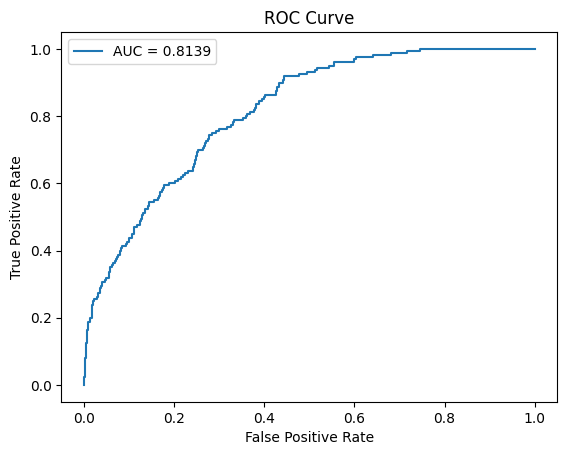

In [22]:
# Plot ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

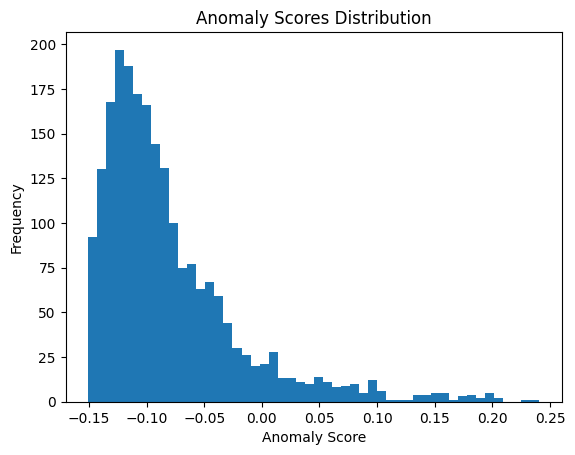

In [23]:
# Visualize anomaly scores
plt.hist(y_test_scores, bins=50)
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Anomaly Scores Distribution')
plt.show()

In [24]:
# Visualize the data distribution (use a subset if too large), coloring true positives, false positives, true negatives, and false negatives
df = pd.DataFrame(X_train)
df['y'] = y_train
df['y_pred'] = clf.predict(X_train)

In [25]:
def label_outcome(row):
    if row['y'] == 1 and row['y_pred'] == 1:
        return 'TP'  # True Positive
    elif row['y'] == 0 and row['y_pred'] == 1:
        return 'FP'  # False Positive
    elif row['y'] == 0 and row['y_pred'] == 0:
        return 'TN'  # True Negative
    elif row['y'] == 1 and row['y_pred'] == 0:
        return 'FN'  # False Negative


In [26]:
df['outcome'] = df.apply(label_outcome, axis=1)
df = df.drop(['y', 'y_pred'], axis=1)
df.head()

,0,1,2,3,4,5,outcome
0,0.28,0.00208,0.017,0.116,0.101,0.115,TN
1,0.74,0.00300,0.012,0.096,0.093,0.103,None
2,0.85,0.00140,0.006,0.124,0.096,0.129,None
3,0.34,0.00680,0.024,0.096,0.104,0.090,None
4,0.46,0.00091,0.024,0.124,0.104,0.118,None


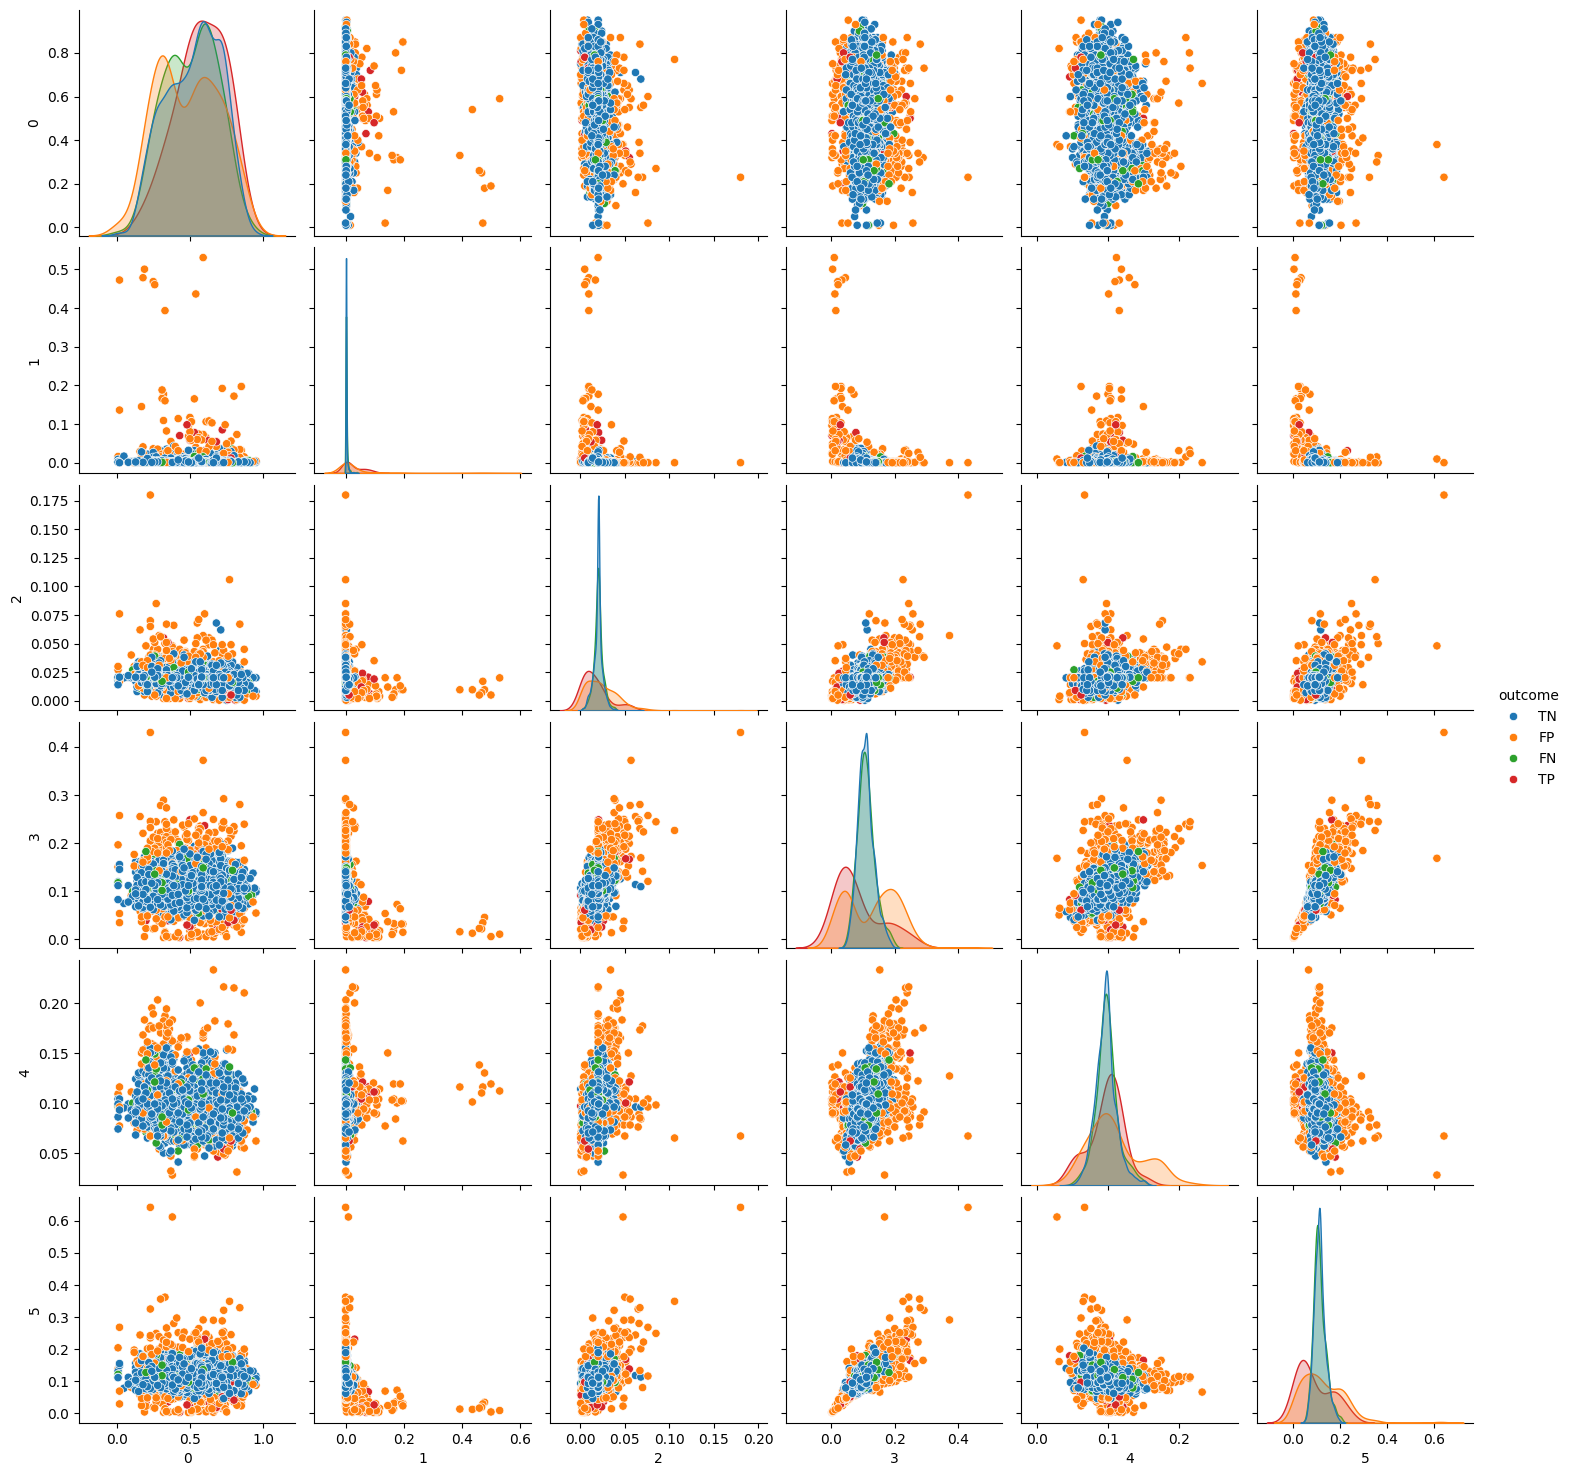

In [27]:
# Visualize the data distribution (use a subset if too large), coloring true positives, false positives, true negatives, and false negatives

pp = sns.pairplot(df, diag_kind='kde', hue='outcome',  # color by outcome
                  diag_kws=dict(common_norm=False))  # scale kde independently for each outcome
plt.show()

## 6. Explainability with SHAP

In [28]:
# find index of first true positive
first_tp_index = df[df['outcome'] == 'TP'].index[0]
print(f"Index of the first True Positive: {first_tp_index}")

Index of the first True Positive: 115


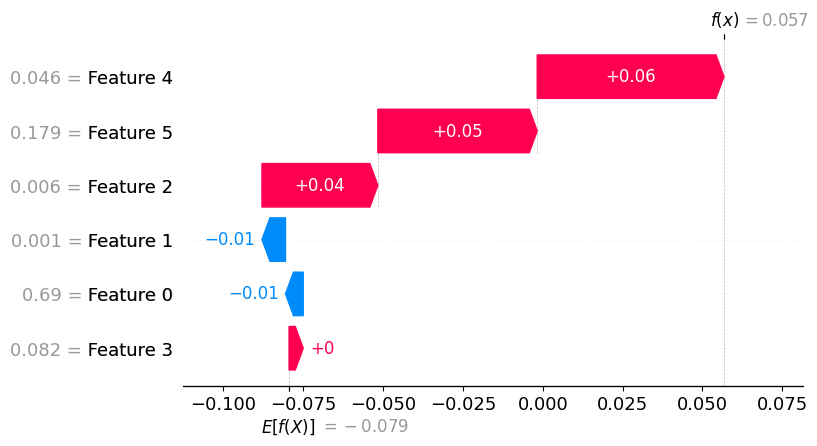

In [29]:
# Fit SHAP explainer and obtain SHAP values for one observation -- TRUE POSITIVE
explainer = shap.explainers.Exact(clf.decision_function, X_train)
shap_values_exact = explainer(np.array([X_train[first_tp_index,]]))
shap.plots.waterfall(shap_values_exact[0])

# PARAMETER TUNING

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from pyod.models.knn import KNN

# Assuming X_train, X_test, y_train, y_test are already defined

# Define the model
model = KNN()

# Define parameter grid
param_grid = {
    'n_neighbors': [5, 10, 15, 20, 25],
    'method': ['largest', 'mean', 'median'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

# Define evaluation metric (ROC AUC in this case)
scoring = 'roc_auc'

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=3, verbose=1)
grid_search.fit(X_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score found: ", grid_search.best_score_)

# Evaluate on test data
y_pred = grid_search.predict(X_test)
roc_auc = roc_auc_score(y_true=y_test, y_score=-grid_search.best_estimator_.decision_function(X_test))
print("ROC AUC on test data: ", roc_auc)

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from pyod.models.iforest import IForest

# Define the model
model = IForest(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [100, 200, 'auto'],
    'contamination': [0.05, 0.1, 0.2]
}

# Define evaluation metric (ROC AUC in this case)
scoring = 'roc_auc'

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=3, verbose=1)
grid_search.fit(X_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score found: ", grid_search.best_score_)
# Evaluate on test data
y_pred = grid_search.predict(X_test)
roc_auc = roc_auc_score(y_true=y_test, y_score=-grid_search.decision_function(X_test))  # Assuming y_true is 0 for all test samples
print("ROC AUC on test data: ", roc_auc)

# Internal GDL project

# TUNING USING GRIDSEARCH

## *1. How do different unsupervised anomaly detectors perform across different datasets?*
Limit research to unsupervised anomaly detectors, on the following ADbench datasets:
* annthyroid,
* campaign,
* census,
* donors, and
* skin

Evaluate performance of AD methods using AUC-ROC. Keep in mind different methods have different hyperparameters. Optimizing hyperparameters requires cross-validation.

### Hints

*You may want to subsample datasets to reduce computational load---make sure to stratify on y to preserve class balance of inliers/outliers.*

*While you can run each dataset as a single experiment, it may be more efficient to build a pipeline.*

**KNN:** K-Nearest Neighbors

**LOF:** Local Outlier Factor

**HBOS:** Histogram-based Outlier Score

**IForest:** Isolation Forest

**PCA:** Principal Component Analysis

**MCD:** Minimum Covariance Determinant

**OCSVM:** One-Class Support Vector Machine

**ABOD:** Angle-Based Outlier Detection

**AutoEncoder:** AutoEncoder

**VAE:** Variational AutoEncoder

**LSCP:** LSCP (Locally Selective Combination of Parallel Outlier Ensembles)

**COF:** Connectivity-Based Outlier Factor

**LOCI:** LOCI (Local Correlation Integral)

**SOD:** Subspace Outlier Detection

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.pca import PCA
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.abod import ABOD
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from pyod.models.lscp import LSCP
from pyod.models.cof import COF
from pyod.models.loci import LOCI
from pyod.models.sod import SOD
from pyod.models.kde import KDE

# Load your dataset and split into train and test sets
# Assuming X contains your features and y contains your labels or anomalies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define models to evaluate
models = {
    'KNN': KNN(),
    'LOF': LOF(),
    'HBOS': HBOS(),
    'IForest': IForest(),
    'PCA': PCA(),
    'MCD': MCD(),
    'OCSVM': OCSVM(),
    'KDE': KDE()
    #'ABOD': ABOD()
    #'COF': COF(),
    #'LOCI': LOCI(),
    #'SOD': SOD()
}

# Define parameter grids for each model
param_grids = {
    'KNN': {
        'n_neighbors': [5, 10, 15, 20],
        'method': ['largest', 'mean', 'median', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
        'leaf_size': [10, 20, 30],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'LOF': {
        'n_neighbors': [5, 10, 15, 20],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'contamination': [0.01, 0.05, 0.1, 0.15],
        'metric': ['minkowski', 'manhattan', 'euclidean']
    },
    'HBOS': {
        'n_bins': [10, 20, 30, 40],
        'alpha': [0.1, 0.3, 0.6, 0.9],
        'contamination': [0.01, 0.05, 0.1, 0.15]
    },
    'IForest': {
        'n_estimators': [50, 100, 150, 200],
        'max_samples': [0.5, 0.7, 1.0],
        'contamination': [0.01, 0.05, 0.1, 0.15],
        'bootstrap': [True, False],
        'max_features': [0.5, 0.7, 1.0],
        'behaviour': ['new', 'old']
    },
    'PCA': {
        'n_components': [2, 5, 10, 20],
        'whiten': [True, False],
        'svd_solver': ['auto', 'full', 'arpack', 'randomized']
    },
    'MCD': {
        'contamination': [0.01, 0.05, 0.1, 0.15]
    },
    'OCSVM': {
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
        'nu': [0.01, 0.05, 0.1, 0.15],
        'gamma': ['auto', 'scale']
    },
    'KDE': {'contamination': [0.01, 0.05, 0.1, 0.15]}
}

# Perform grid search and tune models
best_models = {}
for name, model in models.items():
    param_grid = param_grids[name]
    grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

# Print best models found by GridSearchCV
for name, model in best_models.items():
    print(f"Best model for {name}:")
    print(model)
    print()

# Example of evaluating models using ROC AUC score (or other appropriate metrics)
results = {}
for name, model in best_models.items():
    y_scores = model.decision_function(X_test)
    roc_auc = roc_auc_score(y_test, y_scores)
    results[name] = roc_auc

# Print or analyze results
print("ROC AUC Scores:")
print(results)

In [32]:
from flaml import AutoML

automl = AutoML()

# Specify automl goal and constraint
automl_settings = {
    "time_budget": 1000,       # total running time in seconds
    "task": 'classification', # task type
    "seed": 24545678,         # random seed
    "metric": 'roc_auc',      # use ROC AUC as the metric
}

# Fit the AutoML model with the specified settings
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

[flaml.automl.logger: 07-10 11:37:47] {1680} INFO - task = classification
[flaml.automl.logger: 07-10 11:37:47] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 07-10 11:37:47] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-10 11:37:47] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-10 11:37:47] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-10 11:37:47] {2345} INFO - Estimated sufficient time budget=647s. Estimated necessary time budget=15s.
[flaml.automl.logger: 07-10 11:37:47] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.0063,	best estimator lgbm's best error=0.0063
[flaml.automl.logger: 07-10 11:37:47] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-10 11:37:47] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.0063,	best estimator lgbm's best error=0.0063
[flaml.automl.logger: 07-10 11:37:47

[flaml.automl.logger: 07-10 11:37:51] {2219} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 07-10 11:37:51] {2392} INFO -  at 4.0s,	estimator lgbm's best error=0.0042,	best estimator rf's best error=0.0039
[flaml.automl.logger: 07-10 11:37:51] {2219} INFO - iteration 35, current learner lgbm
[flaml.automl.logger: 07-10 11:37:51] {2392} INFO -  at 4.1s,	estimator lgbm's best error=0.0042,	best estimator rf's best error=0.0039
[flaml.automl.logger: 07-10 11:37:51] {2219} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 07-10 11:37:51] {2392} INFO -  at 4.3s,	estimator extra_tree's best error=0.1999,	best estimator rf's best error=0.0039
[flaml.automl.logger: 07-10 11:37:51] {2219} INFO - iteration 37, current learner lgbm
[flaml.automl.logger: 07-10 11:37:51] {2392} INFO -  at 4.5s,	estimator lgbm's best error=0.0042,	best estimator rf's best error=0.0039
[flaml.automl.logger: 07-10 11:37:51] {2219} INFO - iteration 38, current learner rf
[flaml.auto

[flaml.automl.logger: 07-10 11:38:00] {2219} INFO - iteration 71, current learner rf
[flaml.automl.logger: 07-10 11:38:00] {2392} INFO -  at 13.3s,	estimator rf's best error=0.0036,	best estimator rf's best error=0.0036
[flaml.automl.logger: 07-10 11:38:00] {2219} INFO - iteration 72, current learner extra_tree
[flaml.automl.logger: 07-10 11:38:00] {2392} INFO -  at 13.5s,	estimator extra_tree's best error=0.0671,	best estimator rf's best error=0.0036
[flaml.automl.logger: 07-10 11:38:00] {2219} INFO - iteration 73, current learner extra_tree
[flaml.automl.logger: 07-10 11:38:01] {2392} INFO -  at 13.8s,	estimator extra_tree's best error=0.0473,	best estimator rf's best error=0.0036
[flaml.automl.logger: 07-10 11:38:01] {2219} INFO - iteration 74, current learner extra_tree
[flaml.automl.logger: 07-10 11:38:01] {2392} INFO -  at 14.0s,	estimator extra_tree's best error=0.0473,	best estimator rf's best error=0.0036
[flaml.automl.logger: 07-10 11:38:01] {2219} INFO - iteration 75, curren

[flaml.automl.logger: 07-10 11:38:07] {2219} INFO - iteration 106, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:38:07] {2392} INFO -  at 20.3s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:07] {2219} INFO - iteration 107, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:38:08] {2392} INFO -  at 20.6s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:08] {2219} INFO - iteration 108, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:38:08] {2392} INFO -  at 20.7s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:08] {2219} INFO - iteration 109, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:38:08] {2392} INFO -  at 21.0s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_lim

[flaml.automl.logger: 07-10 11:38:15] {2219} INFO - iteration 139, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:38:15] {2392} INFO -  at 28.5s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:15] {2219} INFO - iteration 140, current learner lgbm
[flaml.automl.logger: 07-10 11:38:16] {2392} INFO -  at 28.8s,	estimator lgbm's best error=0.0039,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:16] {2219} INFO - iteration 141, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:38:16] {2392} INFO -  at 29.0s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:16] {2219} INFO - iteration 142, current learner rf
[flaml.automl.logger: 07-10 11:38:16] {2392} INFO -  at 29.3s,	estimator rf's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.lo

[flaml.automl.logger: 07-10 11:38:28] {2219} INFO - iteration 173, current learner extra_tree
[flaml.automl.logger: 07-10 11:38:28] {2392} INFO -  at 41.5s,	estimator extra_tree's best error=0.0069,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:28] {2219} INFO - iteration 174, current learner extra_tree
[flaml.automl.logger: 07-10 11:38:29] {2392} INFO -  at 41.8s,	estimator extra_tree's best error=0.0069,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:29] {2219} INFO - iteration 175, current learner rf
[flaml.automl.logger: 07-10 11:38:29] {2392} INFO -  at 42.1s,	estimator rf's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:29] {2219} INFO - iteration 176, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:38:29] {2392} INFO -  at 42.3s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.autom

[flaml.automl.logger: 07-10 11:38:40] {2392} INFO -  at 53.4s,	estimator extra_tree's best error=0.0056,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:40] {2219} INFO - iteration 207, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:38:40] {2392} INFO -  at 53.5s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:40] {2219} INFO - iteration 208, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:38:41] {2392} INFO -  at 53.6s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:41] {2219} INFO - iteration 209, current learner rf
[flaml.automl.logger: 07-10 11:38:41] {2392} INFO -  at 53.8s,	estimator rf's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:41] {2219} INFO - iteration 210, current learner xgboost
[flaml.

[flaml.automl.logger: 07-10 11:38:52] {2219} INFO - iteration 240, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:38:52] {2392} INFO -  at 65.3s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:52] {2219} INFO - iteration 241, current learner lgbm
[flaml.automl.logger: 07-10 11:38:53] {2392} INFO -  at 65.7s,	estimator lgbm's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:53] {2219} INFO - iteration 242, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:38:53] {2392} INFO -  at 65.8s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:38:53] {2219} INFO - iteration 243, current learner rf
[flaml.automl.logger: 07-10 11:38:53] {2392} INFO -  at 66.1s,	estimator rf's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.lo

[flaml.automl.logger: 07-10 11:39:02] {2392} INFO -  at 75.3s,	estimator rf's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:39:02] {2219} INFO - iteration 274, current learner rf
[flaml.automl.logger: 07-10 11:39:02] {2392} INFO -  at 75.5s,	estimator rf's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:39:02] {2219} INFO - iteration 275, current learner rf
[flaml.automl.logger: 07-10 11:39:03] {2392} INFO -  at 75.9s,	estimator rf's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:39:03] {2219} INFO - iteration 276, current learner rf
[flaml.automl.logger: 07-10 11:39:03] {2392} INFO -  at 76.2s,	estimator rf's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:39:03] {2219} INFO - iteration 277, current learner rf
[flaml.automl.logger: 07-10 11:39:03] {2392} INFO -  at 76.4s,	estim

[flaml.automl.logger: 07-10 11:39:13] {2392} INFO -  at 85.6s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:39:13] {2219} INFO - iteration 308, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:39:13] {2392} INFO -  at 85.7s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:39:13] {2219} INFO - iteration 309, current learner xgboost
[flaml.automl.logger: 07-10 11:39:13] {2392} INFO -  at 85.9s,	estimator xgboost's best error=0.0045,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:39:13] {2219} INFO - iteration 310, current learner lgbm
[flaml.automl.logger: 07-10 11:39:13] {2392} INFO -  at 86.6s,	estimator lgbm's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:39:13] {2219} INFO - iteration 311, current learner xgboost
[flaml.automl

[flaml.automl.logger: 07-10 11:39:23] {2219} INFO - iteration 341, current learner lgbm
[flaml.automl.logger: 07-10 11:39:24] {2392} INFO -  at 97.2s,	estimator lgbm's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:39:24] {2219} INFO - iteration 342, current learner rf
[flaml.automl.logger: 07-10 11:39:25] {2392} INFO -  at 97.8s,	estimator rf's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:39:25] {2219} INFO - iteration 343, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:39:25] {2392} INFO -  at 97.9s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.logger: 07-10 11:39:25] {2219} INFO - iteration 344, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:39:25] {2392} INFO -  at 98.0s,	estimator xgb_limitdepth's best error=0.0036,	best estimator xgb_limitdepth's best error=0.0036
[flaml.automl.lo

[flaml.automl.logger: 07-10 11:39:33] {2392} INFO -  at 106.0s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:39:33] {2219} INFO - iteration 375, current learner lgbm
[flaml.automl.logger: 07-10 11:39:34] {2392} INFO -  at 106.9s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:39:34] {2219} INFO - iteration 376, current learner xgboost
[flaml.automl.logger: 07-10 11:39:34] {2392} INFO -  at 107.2s,	estimator xgboost's best error=0.0045,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:39:34] {2219} INFO - iteration 377, current learner lgbm
[flaml.automl.logger: 07-10 11:39:36] {2392} INFO -  at 108.7s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:39:36] {2219} INFO - iteration 378, current learner lgbm
[flaml.automl.logger: 07-10 11:39:36] {2392} INFO -  at 109.0s,	estimato

[flaml.automl.logger: 07-10 11:39:54] {2219} INFO - iteration 409, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:39:54] {2392} INFO -  at 127.6s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:39:54] {2219} INFO - iteration 410, current learner xgboost
[flaml.automl.logger: 07-10 11:39:55] {2392} INFO -  at 127.7s,	estimator xgboost's best error=0.0044,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:39:55] {2219} INFO - iteration 411, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:39:55] {2392} INFO -  at 127.8s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:39:55] {2219} INFO - iteration 412, current learner lgbm
[flaml.automl.logger: 07-10 11:39:56] {2392} INFO -  at 128.8s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:39:56] {221

[flaml.automl.logger: 07-10 11:40:14] {2219} INFO - iteration 444, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:40:14] {2392} INFO -  at 147.4s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:40:14] {2219} INFO - iteration 445, current learner lgbm
[flaml.automl.logger: 07-10 11:40:15] {2392} INFO -  at 147.8s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:40:15] {2219} INFO - iteration 446, current learner xgboost
[flaml.automl.logger: 07-10 11:40:15] {2392} INFO -  at 148.0s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:40:15] {2219} INFO - iteration 447, current learner lgbm
[flaml.automl.logger: 07-10 11:40:19] {2392} INFO -  at 152.2s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:40:19] {2219} INFO - iteration 

[flaml.automl.logger: 07-10 11:40:50] {2219} INFO - iteration 479, current learner xgboost
[flaml.automl.logger: 07-10 11:40:50] {2392} INFO -  at 183.2s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:40:50] {2219} INFO - iteration 480, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:40:50] {2392} INFO -  at 183.3s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:40:50] {2219} INFO - iteration 481, current learner lgbm
[flaml.automl.logger: 07-10 11:41:03] {2392} INFO -  at 196.1s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:41:03] {2219} INFO - iteration 482, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:41:03] {2392} INFO -  at 196.3s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:41:03] {221

[flaml.automl.logger: 07-10 11:41:41] {2392} INFO -  at 233.9s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:41:41] {2219} INFO - iteration 514, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:41:41] {2392} INFO -  at 234.1s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:41:41] {2219} INFO - iteration 515, current learner xgboost
[flaml.automl.logger: 07-10 11:41:41] {2392} INFO -  at 234.4s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:41:41] {2219} INFO - iteration 516, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:41:42] {2392} INFO -  at 234.6s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:41:42] {2219} INFO - iteration 517, current learner xgboost
[flaml.automl.logger: 07-10 11:41:42] {

[flaml.automl.logger: 07-10 11:42:18] {2219} INFO - iteration 548, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:42:18] {2392} INFO -  at 271.5s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:42:18] {2219} INFO - iteration 549, current learner extra_tree
[flaml.automl.logger: 07-10 11:42:19] {2392} INFO -  at 271.9s,	estimator extra_tree's best error=0.0055,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:42:19] {2219} INFO - iteration 550, current learner lgbm
[flaml.automl.logger: 07-10 11:42:25] {2392} INFO -  at 278.4s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:42:25] {2219} INFO - iteration 551, current learner lgbm
[flaml.automl.logger: 07-10 11:42:28] {2392} INFO -  at 281.4s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:42:28] {2219} INFO - iter

[flaml.automl.logger: 07-10 11:42:57] {2219} INFO - iteration 582, current learner xgboost
[flaml.automl.logger: 07-10 11:42:57] {2392} INFO -  at 310.2s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:42:57] {2219} INFO - iteration 583, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:42:57] {2392} INFO -  at 310.4s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:42:57] {2219} INFO - iteration 584, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:42:57] {2392} INFO -  at 310.5s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:42:57] {2219} INFO - iteration 585, current learner xgboost
[flaml.automl.logger: 07-10 11:42:58] {2392} INFO -  at 310.8s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:42:58

[flaml.automl.logger: 07-10 11:43:23] {2392} INFO -  at 335.8s,	estimator extra_tree's best error=0.0054,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:43:23] {2219} INFO - iteration 617, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:43:23] {2392} INFO -  at 336.1s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:43:23] {2219} INFO - iteration 618, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:43:23] {2392} INFO -  at 336.2s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:43:23] {2219} INFO - iteration 619, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:43:23] {2392} INFO -  at 336.4s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:43:23] {2219} INFO - iteration 620, current learner rf
[flaml.automl.logger: 07

[flaml.automl.logger: 07-10 11:43:47] {2392} INFO -  at 360.2s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:43:47] {2219} INFO - iteration 651, current learner rf
[flaml.automl.logger: 07-10 11:43:48] {2392} INFO -  at 360.7s,	estimator rf's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:43:48] {2219} INFO - iteration 652, current learner xgboost
[flaml.automl.logger: 07-10 11:43:48] {2392} INFO -  at 361.0s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:43:48] {2219} INFO - iteration 653, current learner lgbm
[flaml.automl.logger: 07-10 11:43:54] {2392} INFO -  at 366.6s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:43:54] {2219} INFO - iteration 654, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:43:54] {2392} INFO -  at 366.8s,	es

[flaml.automl.logger: 07-10 11:44:23] {2219} INFO - iteration 685, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:44:23] {2392} INFO -  at 396.3s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:44:23] {2219} INFO - iteration 686, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:44:23] {2392} INFO -  at 396.5s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:44:23] {2219} INFO - iteration 687, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:44:23] {2392} INFO -  at 396.6s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:44:23] {2219} INFO - iteration 688, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:44:24] {2392} INFO -  at 396.7s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.a

[flaml.automl.logger: 07-10 11:44:40] {2219} INFO - iteration 719, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:44:40] {2392} INFO -  at 413.1s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:44:40] {2219} INFO - iteration 720, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:44:40] {2392} INFO -  at 413.2s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:44:40] {2219} INFO - iteration 721, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:44:40] {2392} INFO -  at 413.4s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:44:40] {2219} INFO - iteration 722, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:44:40] {2392} INFO -  at 413.6s,	estimator xgb_limitdepth's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.a

[flaml.automl.logger: 07-10 11:45:14] {2392} INFO -  at 447.1s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:45:14] {2219} INFO - iteration 754, current learner rf
[flaml.automl.logger: 07-10 11:45:14] {2392} INFO -  at 447.4s,	estimator rf's best error=0.0036,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:45:14] {2219} INFO - iteration 755, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:45:14] {2392} INFO -  at 447.5s,	estimator xgb_limitdepth's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:45:14] {2219} INFO - iteration 756, current learner xgboost
[flaml.automl.logger: 07-10 11:45:15] {2392} INFO -  at 447.7s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:45:15] {2219} INFO - iteration 757, current learner lgbm
[flaml.automl.logger: 07-10 11:45:20] {2392} INFO -  at 453.0s,

[flaml.automl.logger: 07-10 11:45:50] {2392} INFO -  at 483.1s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:45:50] {2219} INFO - iteration 789, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:45:50] {2392} INFO -  at 483.2s,	estimator xgb_limitdepth's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:45:50] {2219} INFO - iteration 790, current learner xgboost
[flaml.automl.logger: 07-10 11:45:50] {2392} INFO -  at 483.3s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:45:50] {2219} INFO - iteration 791, current learner xgboost
[flaml.automl.logger: 07-10 11:45:50] {2392} INFO -  at 483.4s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:45:50] {2219} INFO - iteration 792, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:45:51] {2392

[flaml.automl.logger: 07-10 11:46:26] {2392} INFO -  at 519.3s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:46:26] {2219} INFO - iteration 824, current learner extra_tree
[flaml.automl.logger: 07-10 11:46:28] {2392} INFO -  at 521.6s,	estimator extra_tree's best error=0.0053,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:46:28] {2219} INFO - iteration 825, current learner xgboost
[flaml.automl.logger: 07-10 11:46:29] {2392} INFO -  at 521.8s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:46:29] {2219} INFO - iteration 826, current learner xgboost
[flaml.automl.logger: 07-10 11:46:29] {2392} INFO -  at 522.0s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:46:29] {2219} INFO - iteration 827, current learner lgbm
[flaml.automl.logger: 07-10 11:46:44] {2392} INFO -  at 536.8s,	

[flaml.automl.logger: 07-10 11:48:07] {2392} INFO -  at 620.3s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:48:07] {2219} INFO - iteration 859, current learner lgbm
[flaml.automl.logger: 07-10 11:48:34] {2392} INFO -  at 647.3s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:48:34] {2219} INFO - iteration 860, current learner xgboost
[flaml.automl.logger: 07-10 11:48:34] {2392} INFO -  at 647.5s,	estimator xgboost's best error=0.0041,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:48:34] {2219} INFO - iteration 861, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:48:35] {2392} INFO -  at 647.6s,	estimator xgb_limitdepth's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:48:35] {2219} INFO - iteration 862, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:48:35] {2392} INFO

[flaml.automl.logger: 07-10 11:50:05] {2392} INFO -  at 737.7s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:50:05] {2219} INFO - iteration 894, current learner extra_tree
[flaml.automl.logger: 07-10 11:50:11] {2392} INFO -  at 744.0s,	estimator extra_tree's best error=0.0053,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:50:11] {2219} INFO - iteration 895, current learner xgboost
[flaml.automl.logger: 07-10 11:50:12] {2392} INFO -  at 744.9s,	estimator xgboost's best error=0.0040,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:50:12] {2219} INFO - iteration 896, current learner lgbm
[flaml.automl.logger: 07-10 11:50:15] {2392} INFO -  at 748.5s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:50:15] {2219} INFO - iteration 897, current learner xgboost
[flaml.automl.logger: 07-10 11:50:17] {2392} INFO -  at 749.9s,	est

[flaml.automl.logger: 07-10 11:51:36] {2392} INFO -  at 829.4s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:51:36] {2219} INFO - iteration 929, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:51:37] {2392} INFO -  at 829.7s,	estimator xgb_limitdepth's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:51:37] {2219} INFO - iteration 930, current learner xgboost
[flaml.automl.logger: 07-10 11:51:39] {2392} INFO -  at 832.3s,	estimator xgboost's best error=0.0039,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:51:39] {2219} INFO - iteration 931, current learner xgboost
[flaml.automl.logger: 07-10 11:51:42] {2392} INFO -  at 834.8s,	estimator xgboost's best error=0.0039,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:51:42] {2219} INFO - iteration 932, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:51:42] {2392} I

[flaml.automl.logger: 07-10 11:53:14] {2392} INFO -  at 926.7s,	estimator xgboost's best error=0.0039,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:53:14] {2219} INFO - iteration 964, current learner xgboost
[flaml.automl.logger: 07-10 11:53:14] {2392} INFO -  at 927.3s,	estimator xgboost's best error=0.0039,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:53:14] {2219} INFO - iteration 965, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:53:14] {2392} INFO -  at 927.4s,	estimator xgb_limitdepth's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:53:14] {2219} INFO - iteration 966, current learner lrl1
[flaml.automl.logger: 07-10 11:53:15] {2392} INFO -  at 927.8s,	estimator lrl1's best error=0.0470,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:53:15] {2219} INFO - iteration 967, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:53:15] {2392} INFO

[flaml.automl.logger: 07-10 11:53:56] {2219} INFO - iteration 998, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:53:57] {2392} INFO -  at 969.7s,	estimator xgb_limitdepth's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:53:57] {2219} INFO - iteration 999, current learner xgboost
[flaml.automl.logger: 07-10 11:53:58] {2392} INFO -  at 971.4s,	estimator xgboost's best error=0.0039,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:53:58] {2219} INFO - iteration 1000, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:53:59] {2392} INFO -  at 971.6s,	estimator xgb_limitdepth's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 11:53:59] {2219} INFO - iteration 1001, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:53:59] {2392} INFO -  at 971.7s,	estimator xgb_limitdepth's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger

In [33]:
from sklearn.metrics import roc_auc_score, accuracy_score
pred=automl.predict(X_test)
#y_scores = automl.decision_function(X_test)
acc_automl = accuracy_score(y_test,pred)
score=automl.predict_proba(X_test)
y_score=score[:,1]
roc_automl=roc_auc_score(y_test,y_score)

In [34]:
best_models={'KNN': KNN(algorithm='auto', contamination=0.1, leaf_size=10, method='mean',
   metric='euclidean', metric_params=None, n_jobs=1, n_neighbors=5, p=2,radius=1.0),
             
 'LOF': LOF(algorithm='ball_tree', contamination=0.01, leaf_size=30,
   metric='manhattan', metric_params=None, n_jobs=1, n_neighbors=20,
   novelty=True, p=2),
             
 'HBOS': HBOS(alpha=0.9, contamination=0.01, n_bins=40, tol=0.5),
 'IForest': IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=0.7,
     max_samples=0.5, n_estimators=50, n_jobs=1, random_state=None,
     verbose=0),
             
 'PCA': PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=2,
   n_selected_components=None, random_state=None, standardization=True,
   svd_solver='auto', tol=0.0, weighted=True, whiten=True),
             
 'MCD':  MCD(assume_centered=False, contamination=0.01, random_state=None, 
            store_precision=True, support_fraction=None),
             
 'OCSVM': OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, nu=0.01, shrinking=True, tol=0.001,
    verbose=False),
             
 'KDE': KDE(algorithm='auto', bandwidth=1.0, contamination=0.01, leaf_size=30,
   metric='minkowski', metric_params=None)}

In [35]:
# Example of evaluating models using ROC AUC score (or other appropriate metrics)
results = {}
accuracy={}
for name, model in best_models.items():
    model.fit(X_train, y_train)
    score=model.predict_proba(X_test)
    y_score=score[:,1]
    y_scores = model.decision_function(X_test)
    y_test_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_score)
    acc = accuracy_score(y_test,y_test_pred  )
    results[name] = roc_auc
    accuracy[name] = acc

# Print or analyze results
print("ROC AUC Scores:")
print(results)
print("Accuracy Scores:")
print(accuracy)

ROC AUC Scores:
{'KNN': 0.7673781249999999, 'LOF': 0.770096875, 'HBOS': 0.7543078125, 'IForest': 0.8378062500000001, 'PCA': 0.6861906249999999, 'MCD': 0.919340625, 'OCSVM': 0.649525, 'KDE': 0.54524375}
Accuracy Scores:
{'KNN': 0.8930555555555556, 'LOF': 0.9231481481481482, 'HBOS': 0.9319444444444445, 'IForest': 0.8912037037037037, 'PCA': 0.875462962962963, 'MCD': 0.9342592592592592, 'OCSVM': 0.8662037037037037, 'KDE': 0.9212962962962963}


In [36]:
np.round(results['KNN'],3)

0.767

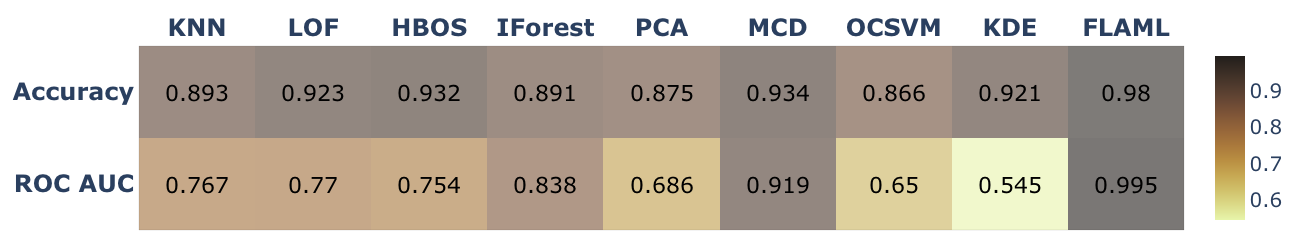

In [37]:
import numpy as np
import plotly.graph_objects as go
from functools import reduce
from itertools import product
from IPython.display import Image
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
z=[ [np.round(results['KNN'],3),np.round(results['LOF'],3),np.round(results['HBOS'],3),
     np.round(results['IForest'],3),np.round(results['PCA'],3),np.round(results['MCD'],3),
    np.round(results['OCSVM'],3),np.round(results['KDE'],3),np.round(roc_automl,3)],
   
   
   [np.round(accuracy['KNN'],3),
    np.round(accuracy['LOF'],3),np.round(accuracy['HBOS'],3),np.round(accuracy['IForest'],3),
    np.round(accuracy['PCA'],3),np.round(accuracy['MCD'],3),np.round(accuracy['OCSVM'],3),
    np.round(accuracy['KDE'],3),np.round(acc_automl,3)]]
x=['<b>KNN</b>', '<b>LOF</b>', '<b>HBOS</b>', '<b>IForest</b>', '<b>PCA</b>','<b>MCD</b>',
   '<b>OCSVM</b>','<b>KDE</b>','<b>FLAML</b>']
y=['<b>ROC AUC</b>','<b>Accuracy</b>']

def get_anno_text(z_value):
    annotations=[]
    a, b = len(z_value), len(z_value[0])
    flat_z = reduce(lambda x,y: x+y, z_value) # z_value.flat if you deal with numpy
    coords = product(range(a), range(b))
    for pos, elem in zip(coords, flat_z):
        annotations.append({'font': {'color': 'black'},
                    'showarrow': False,
                    'text': str(elem),
                    'x': pos[1],
                    'y': pos[0],
                        'font.size':22   })
    return annotations

fig = go.Figure(data=go.Heatmap(
                   z=z,
                   x=x,
                   y=y,
                   hoverongaps = True, colorscale ='turbid',
    opacity=0.6,colorbar=dict(tickfont=dict(size=20)) ))#matter#

fig.update_layout(title={'text': "",
        'y':0.8,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
           plot_bgcolor='rgba(0,0,0,0)',       
    annotations = get_anno_text(z),
                 width=1300,
height=250,xaxis={'side': 'top'},margin=dict(l=20, r=20, t=20, b=20))

fig.update_xaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
    
                 mirror=True)
fig.update_yaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
        
                 mirror=True)
fig.write_image("table2b.png",engine="kaleido")
#plt.savefig("table2a.pdf", format="pdf", bbox_inches="tight")
fig.show()
Image('table2b.png')

# Bank Data

In [38]:
df=pd.read_csv('bank.csv')
df.head()

,age,job=housemaid,job=services,job=admin.,job=blue-collar,job=technician,job=retired,job=management,job=unemployed,job=self-employed,...,previous,poutcome=nonexistent,poutcome=failure,poutcome=success,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,class
0,0.209877,0,0,0,0,0,0,0,0,0,...,0.000000,1,0,0,1.000000,0.882307,0.376569,0.980730,1.000000,0
1,0.296296,0,0,1,0,0,0,0,0,0,...,0.000000,1,0,0,1.000000,0.484412,0.615063,0.981183,1.000000,0
2,0.246914,1,0,0,0,0,0,0,0,0,...,0.000000,1,0,0,0.937500,0.698753,0.602510,0.957379,0.859735,0
3,0.160494,0,1,0,0,0,0,0,0,0,...,0.142857,0,1,0,0.333333,0.269680,0.192469,0.150759,0.512287,0
4,0.530864,0,0,0,1,0,0,0,0,0,...,0.000000,1,0,0,0.333333,0.340608,0.154812,0.174790,0.512287,1


In [39]:
X = df.drop("class", axis=1).values
y = df["class"]

In [40]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (28831, 62)
Test set shape: (12357, 62)


# Define models to evaluate
models = {
    'KNN': KNN(),
    'LOF': LOF(),
    'HBOS': HBOS(),
    'IForest': IForest(),
    'PCA': PCA(),
    'MCD': MCD(),
    'OCSVM': OCSVM(),
    'KDE': KDE()
    #'ABOD': ABOD()
    #'COF': COF(),
    #'LOCI': LOCI(),
    #'SOD': SOD()
}

# Define parameter grids for each model
param_grids = {
    'KNN': {
        'n_neighbors': [5, 10, 15, 20],
        'method': ['largest', 'mean', 'median', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
        'leaf_size': [10, 20, 30],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'LOF': {
        'n_neighbors': [5, 10, 15, 20],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'contamination': [0.01, 0.05, 0.1, 0.15],
        'metric': ['minkowski', 'manhattan', 'euclidean']
    },
    'HBOS': {
        'n_bins': [10, 20, 30, 40],
        'alpha': [0.1, 0.3, 0.6, 0.9],
        'contamination': [0.01, 0.05, 0.1, 0.15]
    },
    'IForest': {
        'n_estimators': [50, 100, 150, 200],
        'max_samples': [0.5, 0.7, 1.0],
        'contamination': [0.01, 0.05, 0.1, 0.15],
        'bootstrap': [True, False],
        'max_features': [0.5, 0.7, 1.0],
        'behaviour': ['new', 'old']
    },
    'PCA': {
        'n_components': [2, 5, 10, 20],
        'whiten': [True, False],
        'svd_solver': ['auto', 'full', 'arpack', 'randomized']
    },
    'MCD': {
        'contamination': [0.01, 0.05, 0.1, 0.15]
    },
    'OCSVM': {
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
        'nu': [0.01, 0.05, 0.1, 0.15],
        'gamma': ['auto', 'scale']
    },
    'KDE': {'contamination': [0.01, 0.05, 0.1, 0.15]}
}

# Perform grid search and tune models
best_models = {}
for name, model in models.items():
    param_grid = param_grids[name]
    grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

# Print best models found by GridSearchCV
for name, model in best_models.items():
    print(f"Best model for {name}:")
    print(model)
    print()

# Example of evaluating models using ROC AUC score (or other appropriate metrics)
results = {}
for name, model in best_models.items():
    y_scores = model.decision_function(X_test)
    roc_auc = roc_auc_score(y_test, y_scores)
    results[name] = roc_auc

# Print or analyze results
print("ROC AUC Scores:")
print(results)

In [41]:
from flaml import AutoML

automl = AutoML()

# Specify automl goal and constraint
automl_settings = {
    "time_budget": 1000,       # total running time in seconds
    "task": 'classification', # task type
    "seed": 24545678,         # random seed
    "metric": 'roc_auc',      # use ROC AUC as the metric
}

# Fit the AutoML model with the specified settings
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

[flaml.automl.logger: 07-10 11:54:42] {1680} INFO - task = classification
[flaml.automl.logger: 07-10 11:54:42] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 07-10 11:54:42] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-10 11:54:42] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-10 11:54:42] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-10 11:54:42] {2345} INFO - Estimated sufficient time budget=4509s. Estimated necessary time budget=104s.
[flaml.automl.logger: 07-10 11:54:42] {2392} INFO -  at 0.5s,	estimator lgbm's best error=0.1013,	best estimator lgbm's best error=0.1013
[flaml.automl.logger: 07-10 11:54:42] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-10 11:54:43] {2392} INFO -  at 1.0s,	estimator lgbm's best error=0.0954,	best estimator lgbm's best error=0.0954
[flaml.automl.logger: 07-10 11:54:

[flaml.automl.logger: 07-10 11:55:09] {2219} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 07-10 11:55:10] {2392} INFO -  at 28.6s,	estimator lgbm's best error=0.0509,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 11:55:10] {2219} INFO - iteration 35, current learner rf
[flaml.automl.logger: 07-10 11:55:11] {2392} INFO -  at 29.1s,	estimator rf's best error=0.1021,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 11:55:11] {2219} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 07-10 11:55:12] {2392} INFO -  at 29.9s,	estimator extra_tree's best error=0.1528,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 11:55:12] {2219} INFO - iteration 37, current learner rf
[flaml.automl.logger: 07-10 11:55:13] {2392} INFO -  at 30.9s,	estimator rf's best error=0.0909,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 11:55:13] {2219} INFO - iteration 38, current learner xgboost
[f

[flaml.automl.logger: 07-10 11:56:32] {2392} INFO -  at 110.8s,	estimator rf's best error=0.0537,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 11:56:32] {2219} INFO - iteration 71, current learner rf
[flaml.automl.logger: 07-10 11:56:35] {2392} INFO -  at 113.3s,	estimator rf's best error=0.0537,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 11:56:35] {2219} INFO - iteration 72, current learner extra_tree
[flaml.automl.logger: 07-10 11:56:36] {2392} INFO -  at 114.0s,	estimator extra_tree's best error=0.1145,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 11:56:36] {2219} INFO - iteration 73, current learner rf
[flaml.automl.logger: 07-10 11:56:39] {2392} INFO -  at 117.6s,	estimator rf's best error=0.0521,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 11:56:39] {2219} INFO - iteration 74, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 11:56:42] {2392} INFO -  at 120.2s,	estimator xgb_li

[flaml.automl.logger: 07-10 11:59:46] {2219} INFO - iteration 106, current learner rf
[flaml.automl.logger: 07-10 11:59:51] {2392} INFO -  at 309.7s,	estimator rf's best error=0.0521,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 11:59:51] {2219} INFO - iteration 107, current learner rf
[flaml.automl.logger: 07-10 11:59:53] {2392} INFO -  at 311.1s,	estimator rf's best error=0.0521,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 11:59:53] {2219} INFO - iteration 108, current learner extra_tree
[flaml.automl.logger: 07-10 11:59:53] {2392} INFO -  at 311.8s,	estimator extra_tree's best error=0.1145,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 11:59:53] {2219} INFO - iteration 109, current learner rf
[flaml.automl.logger: 07-10 12:00:03] {2392} INFO -  at 321.5s,	estimator rf's best error=0.0521,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 12:00:03] {2219} INFO - iteration 110, current learner xgb_l

[flaml.automl.logger: 07-10 12:02:51] {2392} INFO -  at 488.9s,	estimator lgbm's best error=0.0509,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 12:02:51] {2219} INFO - iteration 142, current learner extra_tree
[flaml.automl.logger: 07-10 12:02:51] {2392} INFO -  at 489.5s,	estimator extra_tree's best error=0.1030,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 12:02:51] {2219} INFO - iteration 143, current learner rf
[flaml.automl.logger: 07-10 12:02:55] {2392} INFO -  at 493.0s,	estimator rf's best error=0.0521,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 12:02:55] {2219} INFO - iteration 144, current learner extra_tree
[flaml.automl.logger: 07-10 12:02:55] {2392} INFO -  at 493.8s,	estimator extra_tree's best error=0.1030,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 12:02:55] {2219} INFO - iteration 145, current learner extra_tree
[flaml.automl.logger: 07-10 12:02:57] {2392} INFO -  at 495.7s

[flaml.automl.logger: 07-10 12:08:15] {2219} INFO - iteration 177, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 12:08:18] {2392} INFO -  at 816.8s,	estimator xgb_limitdepth's best error=0.0522,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 12:08:18] {2219} INFO - iteration 178, current learner rf
[flaml.automl.logger: 07-10 12:08:24] {2392} INFO -  at 822.5s,	estimator rf's best error=0.0514,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 12:08:24] {2219} INFO - iteration 179, current learner lgbm
[flaml.automl.logger: 07-10 12:08:28] {2392} INFO -  at 826.3s,	estimator lgbm's best error=0.0509,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 12:08:28] {2219} INFO - iteration 180, current learner rf
[flaml.automl.logger: 07-10 12:08:30] {2392} INFO -  at 828.5s,	estimator rf's best error=0.0514,	best estimator lgbm's best error=0.0509
[flaml.automl.logger: 07-10 12:08:30] {2219} INFO - iteration 181, current l

In [42]:
from sklearn.metrics import roc_auc_score, accuracy_score
pred=automl.predict(X_test)
#y_scores = automl.decision_function(X_test)
acc_automl = accuracy_score(y_test,pred)
score=automl.predict_proba(X_test)
y_score=score[:,1]
roc_automl=roc_auc_score(y_test,y_score)
roc_automl,acc_automl

(0.951493355294537, 0.9185886542040949)

In [43]:
best_models={'KNN': KNN(algorithm='auto', contamination=0.1, leaf_size=10, method='mean',
   metric='euclidean', metric_params=None, n_jobs=1, n_neighbors=5, p=2,radius=1.0),
             
 'LOF': LOF(algorithm='ball_tree', contamination=0.01, leaf_size=30,
   metric='manhattan', metric_params=None, n_jobs=1, n_neighbors=20,
   novelty=True, p=2),
             
 'HBOS': HBOS(alpha=0.9, contamination=0.01, n_bins=40, tol=0.5),
 'IForest': IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=0.7,
     max_samples=0.5, n_estimators=50, n_jobs=1, random_state=None,
     verbose=0),
             
 'PCA': PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=2,
   n_selected_components=None, random_state=None, standardization=True,
   svd_solver='auto', tol=0.0, weighted=True, whiten=True),
             
 'MCD':  MCD(assume_centered=False, contamination=0.01, random_state=None, 
            store_precision=True, support_fraction=None),
             
 'OCSVM': OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, nu=0.01, shrinking=True, tol=0.001,
    verbose=False),
             
 'KDE': KDE(algorithm='auto', bandwidth=1.0, contamination=0.01, leaf_size=30,
   metric='minkowski', metric_params=None)}

In [44]:
# Example of evaluating models using ROC AUC score (or other appropriate metrics)
results = {}
accuracy={}
for name, model in best_models.items():
    model.fit(X_train, y_train)
    score=model.predict_proba(X_test)
    y_score=score[:,1]
    y_scores = model.decision_function(X_test)
    y_test_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_score)
    acc = accuracy_score(y_test,y_test_pred )
    print(acc)
    print(roc_auc )
    results[name] = roc_auc
    accuracy[name] = acc
# Print or analyze results
print("ROC AUC Scores:")
print(results)
print("Accuracy Scores:")
print(accuracy)

0.838148417900785
0.6894043416618184
0.8790159423808368
0.5735382237631754
0.8906692562919802
0.7799417621900404
0.84947802864773
0.7089225579298815
0.8592700493647325
0.7332404961449963
0.8858946346200534
0.7823754789272029
0.8143562353322004
0.45748404012767896
0.8880796309783928
0.6876185852582145
ROC AUC Scores:
{'KNN': 0.6894043416618184, 'LOF': 0.5735382237631754, 'HBOS': 0.7799417621900404, 'IForest': 0.7089225579298815, 'PCA': 0.7332404961449963, 'MCD': 0.7823754789272029, 'OCSVM': 0.45748404012767896, 'KDE': 0.6876185852582145}
Accuracy Scores:
{'KNN': 0.838148417900785, 'LOF': 0.8790159423808368, 'HBOS': 0.8906692562919802, 'IForest': 0.84947802864773, 'PCA': 0.8592700493647325, 'MCD': 0.8858946346200534, 'OCSVM': 0.8143562353322004, 'KDE': 0.8880796309783928}


In [45]:
import numpy as np
import plotly.graph_objects as go
from functools import reduce
from itertools import product
from IPython.display import Image
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
z=[ [np.round(results['KNN'],3),np.round(results['LOF'],3),np.round(results['HBOS'],3),
     np.round(results['IForest'],3),np.round(results['PCA'],3),np.round(results['MCD'],3),
    np.round(results['OCSVM'],3),np.round(results['KDE'],3),np.round(roc_automl,3)],
   
   [np.round(accuracy['KNN'],3),np.round(accuracy['LOF'],3),np.round(accuracy['HBOS'],3),
    np.round(accuracy['IForest'],3),np.round(accuracy['PCA'],3),np.round(accuracy['MCD'],3),
    np.round(accuracy['OCSVM'],3),np.round(accuracy['KDE'],3),np.round(acc_automl,3)]]
x=['<b>KNN</b>', '<b>LOF</b>', '<b>HBOS</b>', '<b>IForest</b>', '<b>PCA</b>','<b>MCD</b>',
   '<b>OCSVM</b>','<b>KDE</b>','<b>FLAML</b>']
y=['<b>ROC AUC</b>','<b>Accuracy</b>']

def get_anno_text(z_value):
    annotations=[]
    a, b = len(z_value), len(z_value[0])
    flat_z = reduce(lambda x,y: x+y, z_value) # z_value.flat if you deal with numpy
    coords = product(range(a), range(b))
    for pos, elem in zip(coords, flat_z):
        annotations.append({'font': {'color': 'black'},
                    'showarrow': False,
                    'text': str(elem),
                    'x': pos[1],
                    'y': pos[0],
                        'font.size':22   })
    return annotations

fig = go.Figure(data=go.Heatmap(
                   z=z,
                   x=x,
                   y=y,
                   hoverongaps = True, colorscale ='turbid',
    opacity=0.6,colorbar=dict(tickfont=dict(size=20)) ))#matter#

fig.update_layout(title={'text': "",
        'y':0.8,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
           plot_bgcolor='rgba(0,0,0,0)',       
    annotations = get_anno_text(z),
                 width=1300,
height=250,xaxis={'side': 'top'},margin=dict(l=20, r=20, t=20, b=20))

fig.update_xaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
    
                 mirror=True)
fig.update_yaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
        
                 mirror=True)
fig.write_image("table2b.png",engine="kaleido")
#plt.savefig("table2a.pdf", format="pdf", bbox_inches="tight")
fig.show()
Image('table2c.png')

FileNotFoundError: No such file or directory: 'table2c.png'

FileNotFoundError: No such file or directory: 'table2c.png'

<IPython.core.display.Image object>

KNN(algorithm='auto', contamination=0.1, leaf_size=10, method='mean',
  metric='euclidean', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

Best model for LOF:
LOF(algorithm='ball_tree', contamination=0.01, leaf_size=30,
  metric='manhattan', metric_params=None, n_jobs=1, n_neighbors=20,
  novelty=True, p=2)

Best model for HBOS:
HBOS(alpha=0.9, contamination=0.01, n_bins=40, tol=0.5)

Best model for IForest:
IForest(behaviour='new', bootstrap=False, contamination=0.15,
    max_features=0.5, max_samples=1.0, n_estimators=50, n_jobs=1,
    random_state=None, verbose=0)

Best model for PCA:
PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=2,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=True)

Best model for MCD:
MCD(assume_centered=False, contamination=0.01, random_state=None,
  store_precision=True, support_fraction=None)

Best model for OCSVM:
OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='scale',
   kernel='rbf', max_iter=-1, nu=0.01, shrinking=True, tol=0.001,
   verbose=False)

Best model for KDE:
KDE(algorithm='auto', bandwidth=1.0, contamination=0.01, leaf_size=30,
  metric='minkowski', metric_params=None)

ROC AUC Scores:
{'KNN': 0.7673781249999999, 'LOF': 0.770096875, 'HBOS': 0.7543078125, 'IForest': 0.8742593750000001, 'PCA': 0.6861906249999999, 'MCD': 0.9199875000000001, 'OCSVM': 0.649525, 'KDE': 0.54524375}

## *2. How consistent are SHAP explanations for different anomaly detectors?*
Where anomaly detectors agree on predictions, do they give rise to similar SHAP value explanations? How about when they disagree?

[link text] (https://)## *3. How does missing data impact anomaly detection?*
Are different anomaly detection algorithms better suited for datasets where there are more missing values?